# LSTM model

# Set up notebook

In [4]:
!nvidia-smi

Fri Jan  3 14:36:03 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [5]:
!pip install sentencepiece

In [6]:
import sys
from google.colab import drive
drive.mount('/content/drive/')
#root_path = 'drive/My Drive/Colab_Notebooks/deeplearning/Sentence_VAE/'
root_path = '/content/drive/My Drive/Colab Notebooks/Sentence_VAE/'
sys.path.append(root_path)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Import modules

In [0]:
import torch
from torch import optim
from IPython.display import Image, display, clear_output
import sentencepiece as spm
import pickle

from torch.utils.data import DataLoader
import time


# Load data and SentencePiece model (See respective notebooks to see how they are made)

#### Load pickle with preprocessed data

In [0]:
data_dict = pickle.load( open( root_path + "FR_data_set_sub10.p", "rb" ))

In [9]:
print(f"train formal len: {len(data_dict['train']['formal'])}")
print(f"train informal len: {len(data_dict['train']['informal'])}")
print(f"test formal len: {len(data_dict['test']['formal'])}")
print(f"test informal len: {len(data_dict['test']['informal'])}")

train formal len: 12824
train informal len: 12824
test formal len: 582
test informal len: 582


#### Load SentencePiece model

In [0]:
# Load sentencepiece model (See local notebook for how to create the sentencepiece model)
sp = spm.SentencePieceProcessor()
sp.Load(root_path + 'FRtraintest16000.model')
VOCAB_SIZE = 16000

# Setting up model Model

### model

In [0]:
from torch import nn

In [0]:
class LSTM_model(nn.Module):
  def __init__(self, embedding_dim, hidden_dim, vocab_size, seq_length):
    super().__init__()
    self.hidden_dim = hidden_dim
    self.embedding_dim = embedding_dim
    self.seq_length = seq_length

    self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
    
    self.dropout = nn.Dropout(p=0.2)

    self.lstm = nn.LSTM(input_size=embedding_dim,
              hidden_size=hidden_dim,
              batch_first = True,
              num_layers=1)
    
    self.linear_out = nn.Linear(in_features=hidden_dim,
                                out_features=vocab_size)
    
  def forward(self, sentence):
    embeds = self.word_embeddings(sentence[:, :-1])
    #embeds = self.dropout(embeds)
    x, (h, c) = self.lstm(embeds)
    output = self.linear_out(x)
    return output

In [0]:
EMBEDDING_DIM = 300
HIDDEN_DIM = 300
BATCH_SIZE = 2048
SEQ_LEN = 12 #padded + EOS + SOS

lstm =  LSTM_model(embedding_dim=EMBEDDING_DIM, hidden_dim=HIDDEN_DIM,
                   vocab_size=VOCAB_SIZE, seq_length=SEQ_LEN).cuda()

### Data loader

In [0]:
from torch.utils.data import DataLoader
training_data = data_dict["train"]["formal"] + data_dict["train"]["informal"]
train_data_loader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)

test_data = data_dict["test"]["formal"] + data_dict["test"]["informal"]
test_data_loader = DataLoader(test_data, batch_size= BATCH_SIZE)



### Optimizer

In [0]:
optimizer = optim.Adam(lstm.parameters(), lr=0.0006)

### Loss function

In [0]:
from torch.nn import functional as F

def loss_func(recon_sentence, sentence):
  # Reconstruction error, log[p(x|z)]
  # Sum over features
  CE = F.cross_entropy(recon_sentence, sentence, reduction='none') # Is the loss function correct?
  CE = CE.sum(1).mean()

  return CE

### Training and test functions

In [0]:
def train(epoch):
    lstm.train()
    start_time = time.time()
    epoch_loss = 0
    for index, sentence in enumerate(train_data_loader):
        sentence = torch.LongTensor(sentence)
        sentence = sentence.cuda()
        optimizer.zero_grad()
        output = lstm.forward(sentence)
        loss = loss_func(output.permute(0,2,1), sentence[:,1:])
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss /= N_train
    return epoch_loss


def test(epoch):
    lstm.eval()
    with torch.no_grad(): # No grads needed and we don't want to run out of mem
      epoch_loss = 0
      for index, sentence in enumerate(test_data_loader):
          sentence = torch.LongTensor(sentence)
          sentence = sentence.cuda()
          output = lstm.forward(sentence)
          loss = loss_func(output.permute(0,2,1), sentence[:,1:])
          epoch_loss += loss.item()
      epoch_loss /= N_test
    return epoch_loss


# simpler plot for LSTM model

import matplotlib.pyplot as plt

def plot_loss(train_arr, test_arr):
  plt.figure()
  plt.title("Loss")
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.plot(train_arr)
  plt.plot(test_arr)
  plt.legend(['Train', 'Test'])
  plt.show()

## Training loop

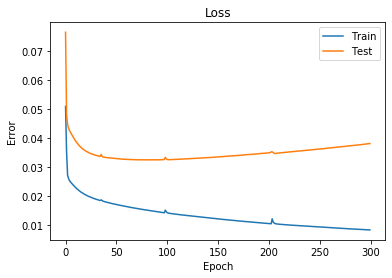

Epoch 299: time: 3.0941975116729736
loss: 0.008265316895373673


In [0]:
N_epochs = 600
N_train = len(training_data)
N_test = len(test_data)


train_loss_arr = []
test_loss_arr = []
for epoch in range(N_epochs//2):
    lstm.train()
    start = time.time()

    train_loss = train(epoch)
    train_loss_arr.append(train_loss)


    test_loss = test(epoch)
    test_loss_arr.append(test_loss)
 

    plot_loss(train_loss_arr, test_loss_arr)
    print(f"Epoch {epoch}: time: {time.time() - start}")
    print(f"loss: {train_loss}")
    clear_output(wait=True)

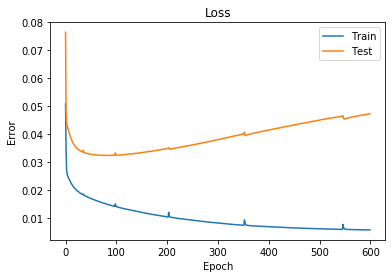

Epoch 599: time: 3.1017813682556152
loss: 0.005798852376765336


In [0]:
for epoch in range(N_epochs//2, N_epochs):
    lstm.train()
    start = time.time()

    train_loss = train(epoch)
    train_loss_arr.append(train_loss)


    test_loss = test(epoch)
    test_loss_arr.append(test_loss)
 

    plot_loss(train_loss_arr, test_loss_arr)
    print(f"Epoch {epoch}: time: {time.time() - start}")
    print(f"loss: {train_loss}")
    clear_output(wait=True)

#### save model

In [0]:
torch.save(lstm.state_dict(), root_path + "trained_models/" + "lstm_model.pt")

#### Optional load model

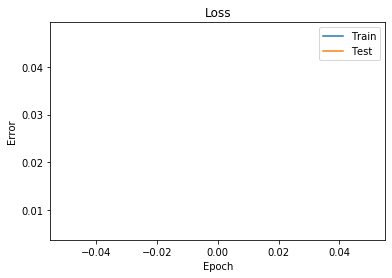

Epoch 0: time: 3.174818277359009
loss: 0.00576473542919623


In [20]:
N_epochs = 600
N_train = len(training_data)
N_test = len(test_data)
train_loss_arr = []
test_loss_arr = []

lstm =  LSTM_model(embedding_dim=EMBEDDING_DIM, hidden_dim=HIDDEN_DIM,
                  vocab_size=VOCAB_SIZE, seq_length=SEQ_LEN).cuda()

lstm.load_state_dict(torch.load(root_path + "trained_models/" + "lstm_model.pt"))

for epoch in range(1):
    lstm.train()
    start = time.time()

    train_loss = train(epoch)
    train_loss_arr.append(train_loss)


    test_loss = test(epoch)
    test_loss_arr.append(test_loss)
 

    plot_loss(train_loss_arr, test_loss_arr)
    print(f"Epoch {epoch}: time: {time.time() - start}")
    print(f"loss: {train_loss}")
    clear_output(wait=True)


## Results

#### Loss of trained model

In [21]:
print(f"Loss \nTrain: {train_loss_arr[-1]} Test: {test_loss_arr[-1]}")

Loss 
Train: 0.00576473542919623 Test: 0.04728010184166767


#### Qualitative results

In [0]:
import numpy as np

In [0]:
def print_single_reconstruction_with_corrections(sentence_in_batch, data_loader):
    lstm.eval()
    test_batch = next(iter(data_loader))
    test_sentence = test_batch[sentence_in_batch]
    test_sentence_string = sp.decode_ids(test_sentence.tolist())
    output = lstm.forward(test_sentence.unsqueeze(0).cuda()) # This view needs to be double checked
    output = torch.sigmoid(output)
    output_ids = output[0,:,:]
    recon_ids = [int(np.argmax(word)) for word in output_ids.cpu().detach().numpy()]
    recon_sentence = sp.decode_ids(recon_ids)
    recon_print = "Reconstructed sentence:"
    real_print = "Real sentence:"
    print(f"{recon_print:<30} {recon_sentence:<50}\n")
    print(f"{real_print:<30} {test_sentence_string:<50}")
    lstm.train()



In [0]:
  print_single_reconstruction_with_corrections(sentence_in_batch=1, data_loader=train_data_loader)

Reconstructed sentence:        i is a i call challange!                          

Real sentence:                 this is what we call challange!                   


In [0]:
def print_single_reconstruction(sentence_in_batch, data_loader):
    lstm.eval()
    test_batch = next(iter(data_loader))
    test_sentence = test_batch[sentence_in_batch]
    test_sentence_string = sp.decode_ids(test_sentence.tolist())
    iterative_sentence_string = test_sentence[0]
    for i in range(len(test_sentence)):
      output = 

SyntaxError: ignored

In [0]:
for i in range(10):
  print_single_reconstruction_with_corrections(sentence_in_batch=i, data_loader=train_data_loader)
  print('*******')

Reconstructed sentence:        i am do it extreemely unattractive.               

Real sentence:                 i just find it extreemely unattractive.           
*******
Reconstructed sentence:        i am that you are love her.                       

Real sentence:                 i believe that you still love her.                
*******
Reconstructed sentence:        i the way, i am miss him terribly!                

Real sentence:                 by the way, i will miss him terribly!             
*******
Reconstructed sentence:        i is not though every kiss is the first.          

Real sentence:                 it is as if every kiss is the first.              
*******
Reconstructed sentence:        i life do not make any sence.                     

Real sentence:                 your questions do not make any sence.             
*******
Reconstructed sentence:        i am not know with war, way.                      

Real sentence:                 i do not mean with wa